In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from metpy.plots import USCOUNTIES
import geopandas
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date
from dateutil import tz
import glob

%matplotlib inline

In [12]:
# Read in Shapefile
d = date.today()
date = f'{d:%d}'
month = f'{d:%m}'

cat_gdf = geopandas.read_file(glob.glob(f'data/98e{date}*.shp')[-1])

In [13]:
# Set Coordinate Reference System for the map
map_crs = ccrs.LambertConformal(central_latitude=35, central_longitude=-100, standard_parallels=(30, 60))

# Set Coordinate Reference System from the Shapefile Data
data_crs = ccrs.PlateCarree()

In [14]:
# Set colors
cat_plot_colors = {'Marginal (5-10%)': 'green',
                   'Slight (10-20%)': 'yellow',
                   'Moderate (20-50%)': 'red',
                   'High (> 50%)': 'magenta'}

# Generate legend patches
legend_patches = []
for risk in cat_plot_colors.keys():
    patch = mpatches.Patch(color=cat_plot_colors[risk], label=risk)
    legend_patches.append(patch)

In [15]:
# Get time data
start_time = cat_gdf['START_TIME'][0]
end_time = cat_gdf['END_TIME'][0]

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

def convert_datetime_from_wpc_to_local(string):
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

def get_valid_day(string):
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

valid_day = get_valid_day(start_time)

start_time = convert_datetime_from_wpc_to_local(start_time)
end_time = convert_datetime_from_wpc_to_local(end_time)


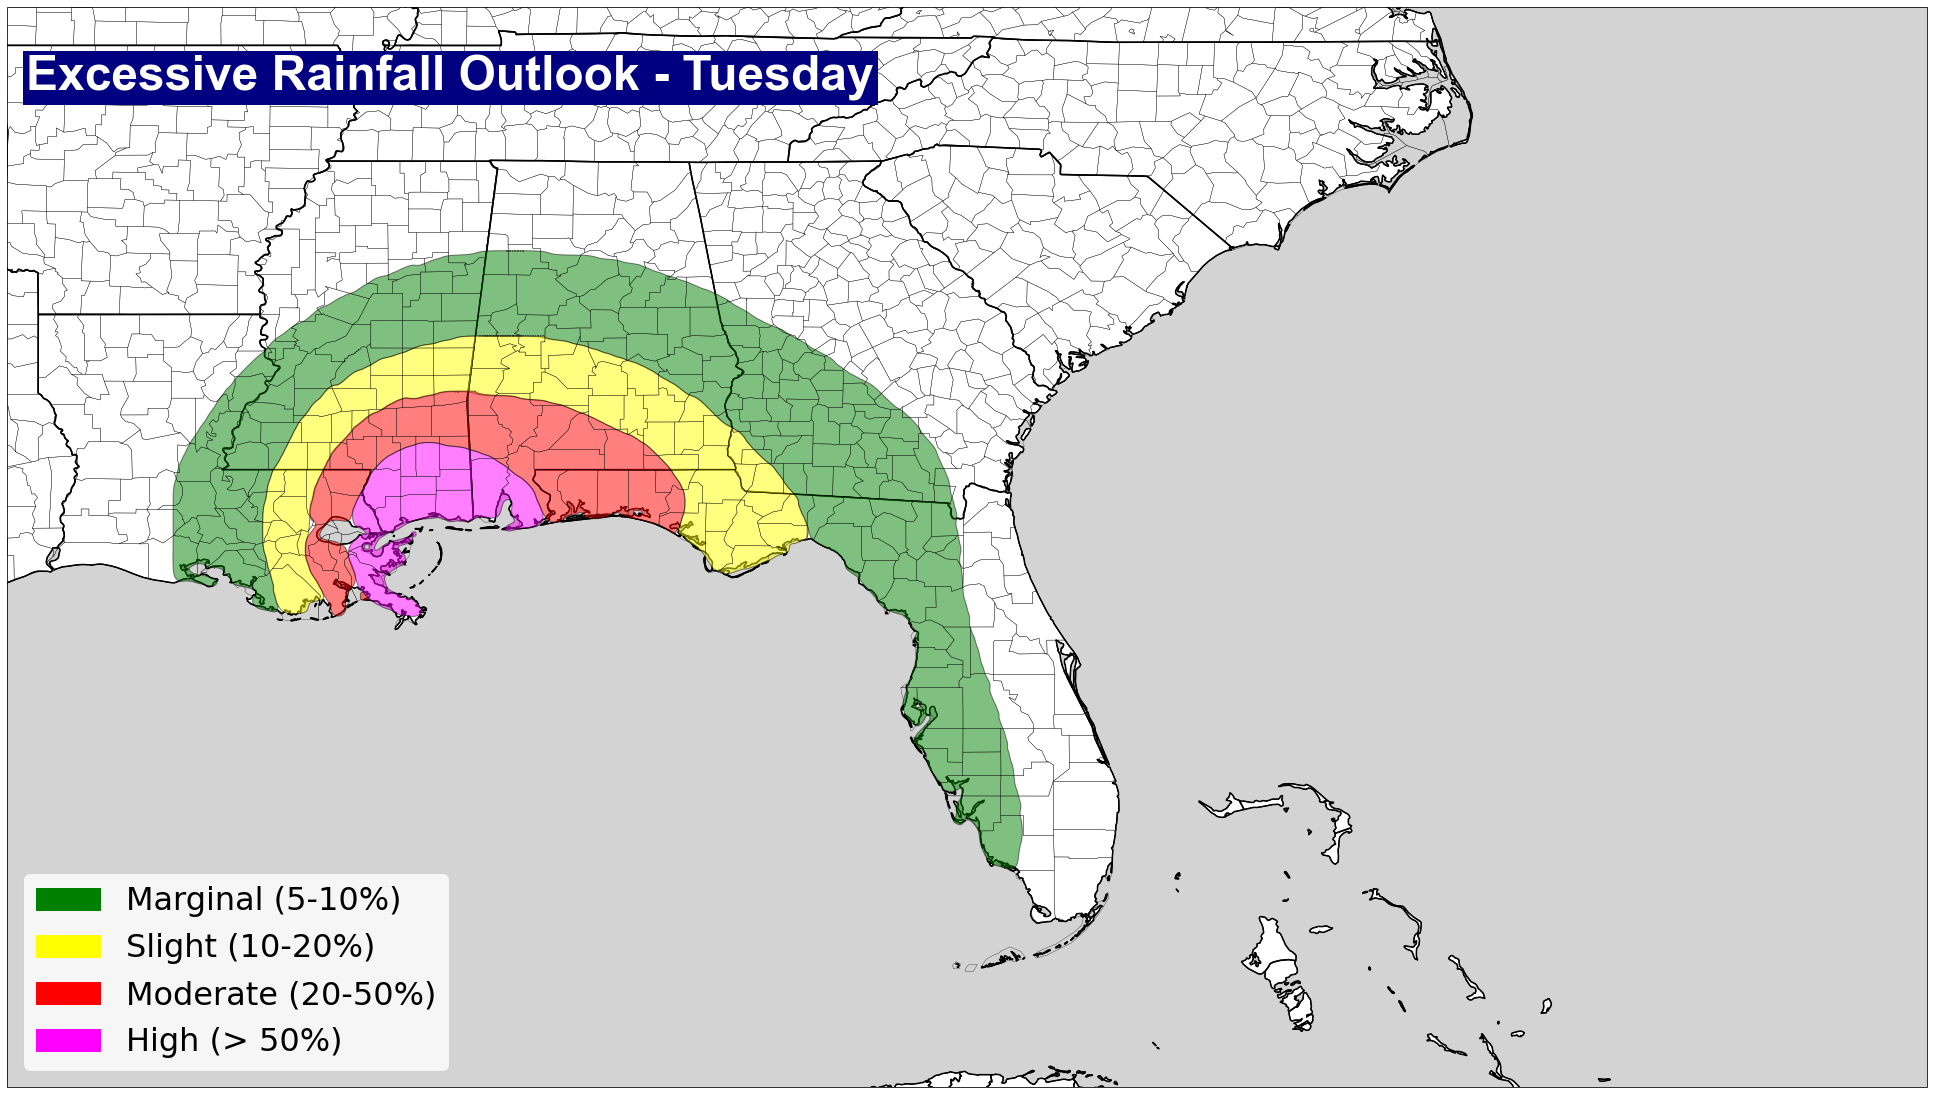

In [16]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=data_crs)

ax.set_extent([-89, -75, 23, 37], data_crs)
ax.set_adjustable('datalim')

# Setup borders (states, countries, coastlines, etc)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='black', zorder=5, linewidth=0.3)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.5)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')

for key in cat_plot_colors.keys():
    geometries = cat_gdf[cat_gdf['OUTLOOK'] == key]
    # Check to see if there an area outlooked at all. If so, add the polygons to the map.
    if len(geometries) > 0:
        ax.add_geometries(geometries['geometry'], crs=data_crs,
                          facecolor=cat_plot_colors[key], edgecolor='black',
                          alpha=0.5)

# Plot the legend
plt.legend(handles=legend_patches, fontsize=32, loc='lower left')

ax.set_title(f'Excessive Rainfall Outlook - {valid_day}', loc='left', 
             ha='left', va='top', fontsize=48, color='white', zorder=15,
             fontweight='bold', fontname='Arial', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'wpc'
plt.savefig(f'{graphics_dir}/ero_day2.png', dpi=72)